In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec


In [2]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
# df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")
# exclude_stn = []
# for stn_id in df["ID"]:
#     bom_id = str(stn_id).zfill(6)
#     if not os.path.exists(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_500km/{stn_id}_station_moving_list_all_events.csv'):
#         exclude_stn.append(stn_id)
# ## mannually remove some faulty stations
# df = df[~df["ID"].isin(exclude_stn)]
df= pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_daily_stations_1960_both.csv")

In [4]:
len(df["ID"])

2070

## number of neighbours

In [5]:
def calc_stn_count(spec_id):
    count = []
    df_stns = pd.read_csv(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1960_500km/{spec_id}_station_moving_list_all_events.csv')
    for days in range(0,df_stns["Day"].max()+1):
        count.append(len(df_stns[(df_stns["Day"]==days) & (df_stns["distance"]<=500.0)]))
    return np.nanmean(count)  

In [6]:
max_pool=24
with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(calc_stn_count,
                   df["ID"]),
            total=len(df["ID"]),
            position=0, leave=True
        )
    )
p.join()

100%|██████████| 2070/2070 [01:46<00:00, 19.37it/s]


In [7]:
mean_count = [data for data in pool_outputs]
df["neighb_count"] = mean_count


In [8]:
base_cmap = cmc.imola # Choose a base colormap
colors = base_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
custom_cmap = LinearSegmentedColormap.from_list("Custom_nuuk", colors)

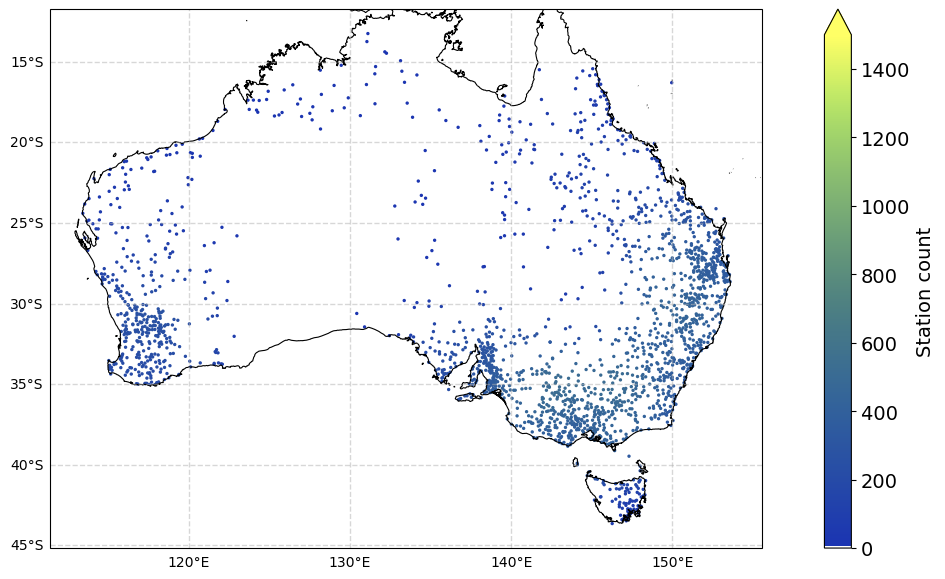

In [9]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s = 2, c= mean_count, cmap=custom_cmap,vmin=0,vmax=1500,#norm=mcolors.LogNorm(vmax=1000),
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Station count")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [10]:
df.to_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_staitons_count_inc_500km_1960.csv")


## Figure 1

In [5]:
# Load the shapefile of regions
regions_gdf = gpd.read_file("/g/data/k10/dl6968/Rain_gauge_scale/data/NRM_modified/NRM_modified.shp")  # Replace with your shapefile path

In [6]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
stations_with_regions = gpd.sjoin(stations_gdf, regions_gdf, how="left", predicate="within")


In [7]:
WT_stn = stations_with_regions[stations_with_regions["code"]=="WT"]
SSWFW_stn = stations_with_regions[stations_with_regions["code"]=="SSWFW"] # SFW
SSWFE_stn = stations_with_regions[stations_with_regions["code"]=="SSWFE"] # SFE
SSVW_stn = stations_with_regions[stations_with_regions["code"]=="SSVW"] # VICW
SSVE_stn = stations_with_regions[stations_with_regions["code"]=="SSVE"] # VICE
SSTW_stn = stations_with_regions[stations_with_regions["code"]=="SSTW"] # TASW
SSTE_stn = stations_with_regions[stations_with_regions["code"]=="SSTE"] # TASE
RW_stn = stations_with_regions[stations_with_regions["code"]=="RW"]
RE_stn = stations_with_regions[stations_with_regions["code"]=="RE"]
MNW_stn = stations_with_regions[stations_with_regions["code"]=="MNW"]
MNE_stn = stations_with_regions[stations_with_regions["code"]=="MNE"]
MB_stn = stations_with_regions[stations_with_regions["code"]=="MB"]
ECS_stn = stations_with_regions[stations_with_regions["code"]=="ECS"]
ECN_stn = stations_with_regions[stations_with_regions["code"]=="ECN"]
CS_stn = stations_with_regions[stations_with_regions["code"]=="CS"]

In [14]:
df_neib = pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_staitons_count_inc_500km_1960.csv")

In [15]:
geometry = [Point(xy) for xy in zip(df_neib["Longitude"], df_neib["Latitude"])]
neib_gdf = gpd.GeoDataFrame(df_neib, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
neib_with_regions = gpd.sjoin(neib_gdf, regions_gdf, how="left", predicate="within")


In [16]:
WT_neib =  neib_with_regions[neib_with_regions["code"]=="WT"]
SSWFW_neib =  neib_with_regions[neib_with_regions["code"]=="SSWFW"]
SSWFE_neib =  neib_with_regions[neib_with_regions["code"]=="SSWFE"]
SSVW_neib =  neib_with_regions[neib_with_regions["code"]=="SSVW"]
SSVE_neib =  neib_with_regions[neib_with_regions["code"]=="SSVE"]
SSTW_neib =  neib_with_regions[neib_with_regions["code"]=="SSTW"]
SSTE_neib =  neib_with_regions[neib_with_regions["code"]=="SSTE"]
RW_neib =  neib_with_regions[neib_with_regions["code"]=="RW"]
RE_neib =  neib_with_regions[neib_with_regions["code"]=="RE"]
MNW_neib =  neib_with_regions[neib_with_regions["code"]=="MNW"]
MNE_neib =  neib_with_regions[neib_with_regions["code"]=="MNE"]
MB_neib =  neib_with_regions[neib_with_regions["code"]=="MB"]
ECS_neib =  neib_with_regions[neib_with_regions["code"]=="ECS"]
ECN_neib =  neib_with_regions[neib_with_regions["code"]=="ECN"]
CS_neib = neib_with_regions[neib_with_regions["code"]=="CS"]

In [17]:
base_cmap = cmc.imola # Choose a base colormap
colors = base_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
custom_cmap = LinearSegmentedColormap.from_list("Custom_nuuk", colors)

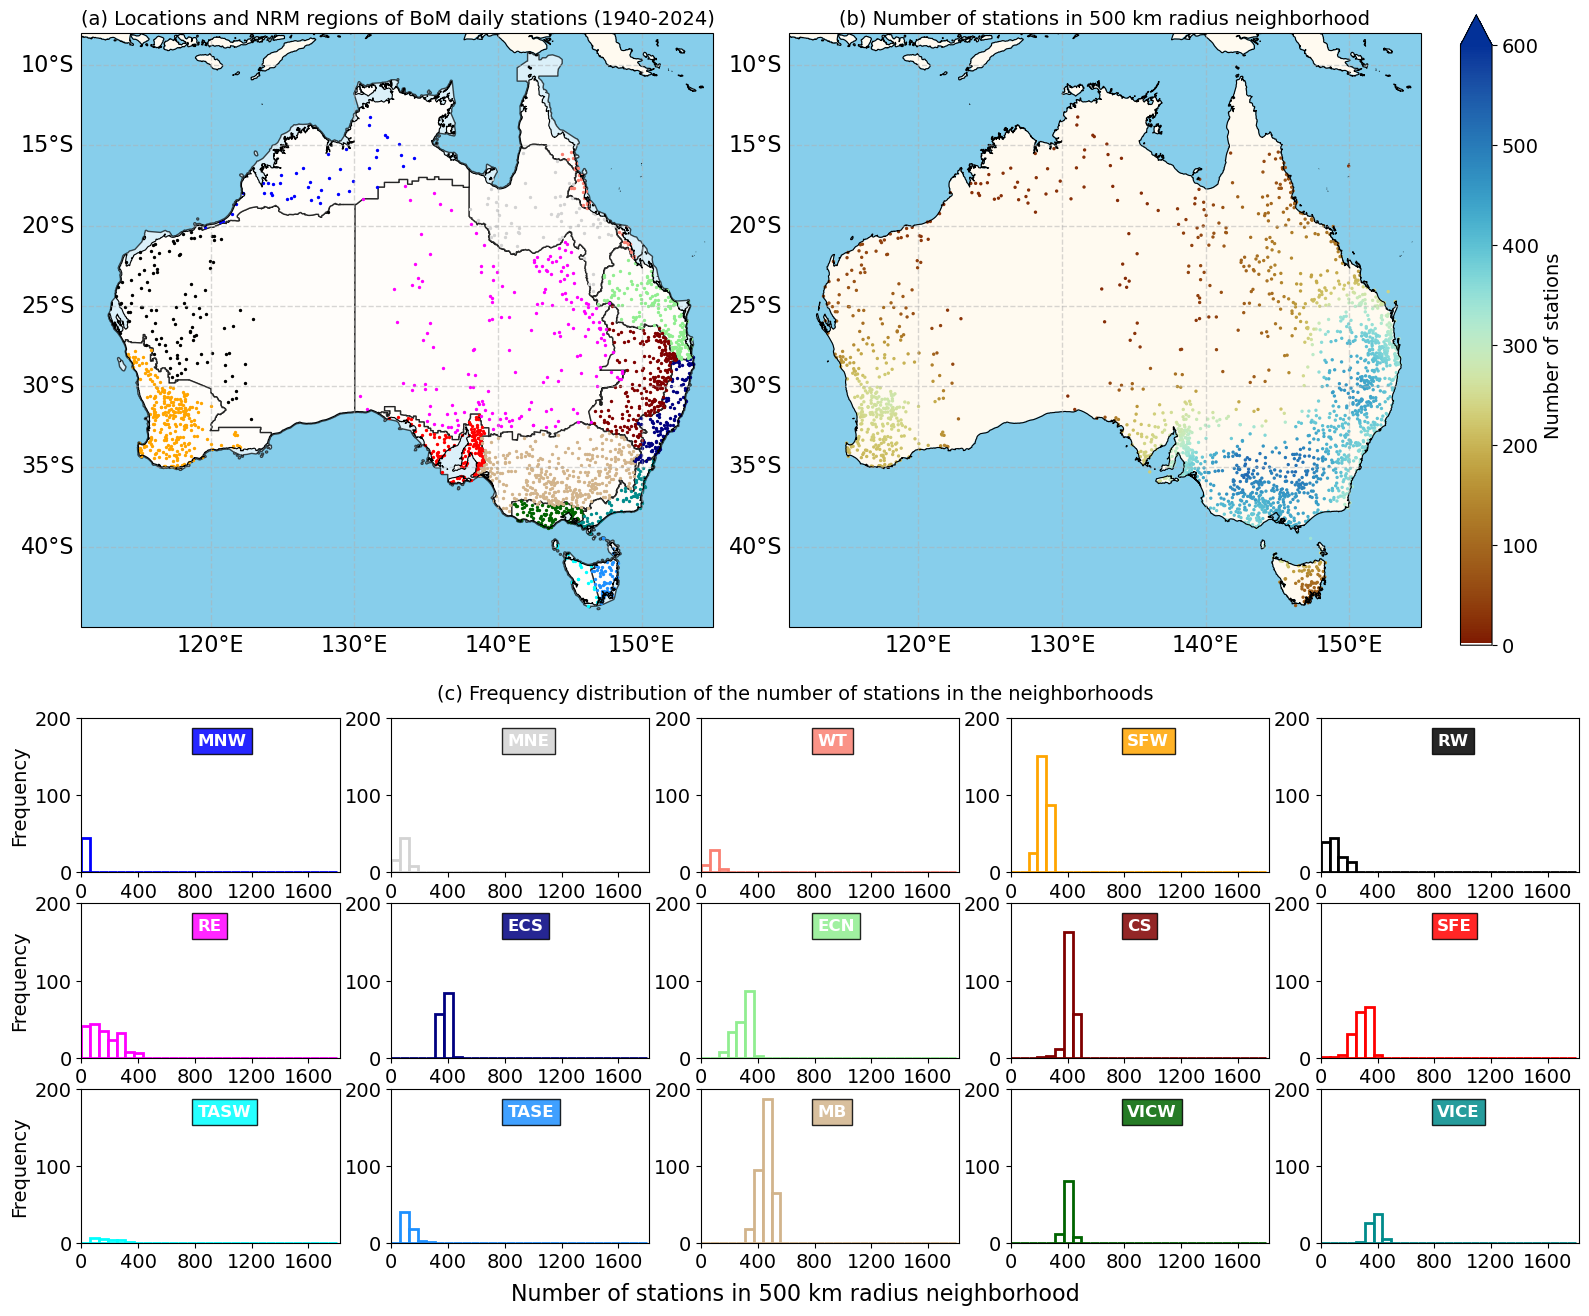

In [30]:
fig = plt.figure(figsize=(16,14))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.25],height_ratios=[1.5, 1])  # First column is 1, second is 1.5x wider

# First subplot (narrower column)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

plt.scatter(WT_stn["Longitude"], WT_stn["Latitude"], s = 2, color= "salmon",  label="WT",
            transform=ccrs.PlateCarree())
plt.scatter(SSWFW_stn["Longitude"], SSWFW_stn["Latitude"], s = 2, color= "orange",  label="SFW",
            transform=ccrs.PlateCarree())
plt.scatter(SSWFE_stn["Longitude"], SSWFE_stn["Latitude"], s = 2, color= "red",  label="SFE",
            transform=ccrs.PlateCarree())
plt.scatter(SSVW_stn["Longitude"], SSVW_stn["Latitude"], s = 2, color= "darkgreen",  label="VICW",
            transform=ccrs.PlateCarree())
plt.scatter(SSVE_stn["Longitude"], SSVE_stn["Latitude"], s = 2, color= "darkcyan",  label="VICE",
            transform=ccrs.PlateCarree())
plt.scatter(SSTW_stn["Longitude"], SSTW_stn["Latitude"], s = 2, color= "cyan",  label="TASW",
            transform=ccrs.PlateCarree())
plt.scatter(SSTE_stn["Longitude"], SSTE_stn["Latitude"], s = 2, color= "dodgerblue",  label="TASE",
            transform=ccrs.PlateCarree())
plt.scatter(RW_stn["Longitude"], RW_stn["Latitude"], s = 2, color= "black",  label="RW",
            transform=ccrs.PlateCarree())
plt.scatter(RE_stn["Longitude"], RE_stn["Latitude"], s = 2, color= "fuchsia",  label="RE",
            transform=ccrs.PlateCarree())
plt.scatter(MNW_stn["Longitude"], MNW_stn["Latitude"], s = 2, color= "blue",  label="MNW",
            transform=ccrs.PlateCarree())
plt.scatter(MNE_stn["Longitude"], MNE_stn["Latitude"], s = 2, color= "lightgray",  label="MNE",
            transform=ccrs.PlateCarree())
plt.scatter(MB_stn["Longitude"], MB_stn["Latitude"], s = 2, color= "tan",  label="MB",
            transform=ccrs.PlateCarree())
plt.scatter(ECS_stn["Longitude"], ECS_stn["Latitude"], s = 2, color= "navy",  label="ECS",
            transform=ccrs.PlateCarree())
plt.scatter(ECN_stn["Longitude"], ECN_stn["Latitude"], s = 2, color= "lightgreen",  label="ECN",
            transform=ccrs.PlateCarree())
plt.scatter(CS_stn["Longitude"], CS_stn["Latitude"], s = 2, color= "maroon",  label="CS",
            transform=ccrs.PlateCarree())
plt.title("(a) Locations and NRM regions of BoM daily stations (1940-2024)")
regions_gdf.plot(ax=ax1, color="w", edgecolor="black", alpha=0.7,zorder=0)


# plt.legend(loc="lower left", ncol =2)
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}  # Font size for longitude labels
gl.ylabel_style = {'size': 16}  # Font size for latitude labels
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  
ax1.set_ylim([-45,-8])
ax1.set_xlim([111,155])

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
plt.scatter(df_neib["Longitude"], df_neib["Latitude"], s = 2, c= df_neib["neighb_count"], cmap=custom_cmap,vmin=0,vmax=600,#norm=mcolors.LogNorm(vmax=1000),
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max",shrink=0.8)
cbar.ax.set_ylabel("Number of stations")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}  # Font size for longitude labels
gl.ylabel_style = {'size': 16}  # Font size for latitude labels
ax2.set_ylim([-45,-8])
ax2.set_xlim([111,155])

ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  
## have this so the plots are the same size
regions_gdf.plot(ax=ax2, color="w", edgecolor="w", alpha=0,zorder=0)
plt.title("(b) Number of stations in 500 km radius neighborhood")



gs_bottom = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs[1, :], wspace=0.2, hspace=0.2)

datasets = [
    (MNW_neib, "blue"), (MNE_neib, "lightgray"), (WT_neib, "salmon"),
    (SSWFW_neib, "orange"), (RW_neib, "black"), (RE_neib, "fuchsia"),
    (ECS_neib, "navy"), (ECN_neib, "lightgreen"), (CS_neib, "maroon"),
    (SSWFE_neib, "red"), (SSTW_neib, "cyan"), (SSTE_neib, "dodgerblue"),
    (MB_neib, "tan"), (SSVW_neib, "darkgreen"), (SSVE_neib, "darkcyan")
]

for i, ((data, color), label) in enumerate(zip(datasets, [
    "MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"])):
    
    ax_hist = fig.add_subplot(gs_bottom[i // 5, i % 5])
    ax_hist.hist(data["neighb_count"], histtype="bar", bins=np.linspace(0, 1800, 30), 
                 facecolor="w", edgecolor=color, linewidth=2)
    ax_hist.set_ylim([0, 200])
    ax_hist.set_xlim([0, 1820])
    ax_hist.set_xticks([0, 400,  800, 1200, 1600])
    
    # Add label inside each histogram panel
    ax_hist.text(0.45, 0.9, label, transform=ax_hist.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=color, alpha=0.85))

    # Add y-axis labels only to the first column
    if i % 5 == 0:
        ax_hist.set_ylabel("Frequency")
# gs_bottom.suptitle("(c) Frequency distribution of the number of stations in the neighborhoods")
fig.suptitle("(c) Frequency distribution of the number of stations in the neighborhoods",
             fontsize=14, y=0.43, x=0.5, ha='center')

fig.text(0.5, -0.01, "Number of stations in 500 km radius neighborhood", ha='center', fontsize=16)


plt.tight_layout()

plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_01_1960.png", dpi=200, bbox_inches="tight")

## seasonal P90

In [22]:
df_pc_season = pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_stn_p90_monthly.csv")
df_p90 = df_pc_season[df_pc_season["ID"].isin(df["ID"])]

In [23]:
df_season = df_p90.copy()
df_season["DJF"] = (df_p90["Dec"].values + df_p90["Jan"].values + df_p90["Feb"].values)/3
df_season["MAM"]  = (df_p90["Mar"].values + df_p90["Apr"].values + df_p90["May"].values)/3
df_season["JJA"]  = (df_p90["Jun"].values + df_p90["Jul"].values + df_p90["Aug"].values)/3
df_season["SON"]  = (df_p90["Sep"].values + df_p90["Oct"].values + df_p90["Nov"].values)/3


In [24]:
base_cmap = cmc.roma # Choose a base colormap
colors = base_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
custom_cmap = LinearSegmentedColormap.from_list("Custom_roma", colors)

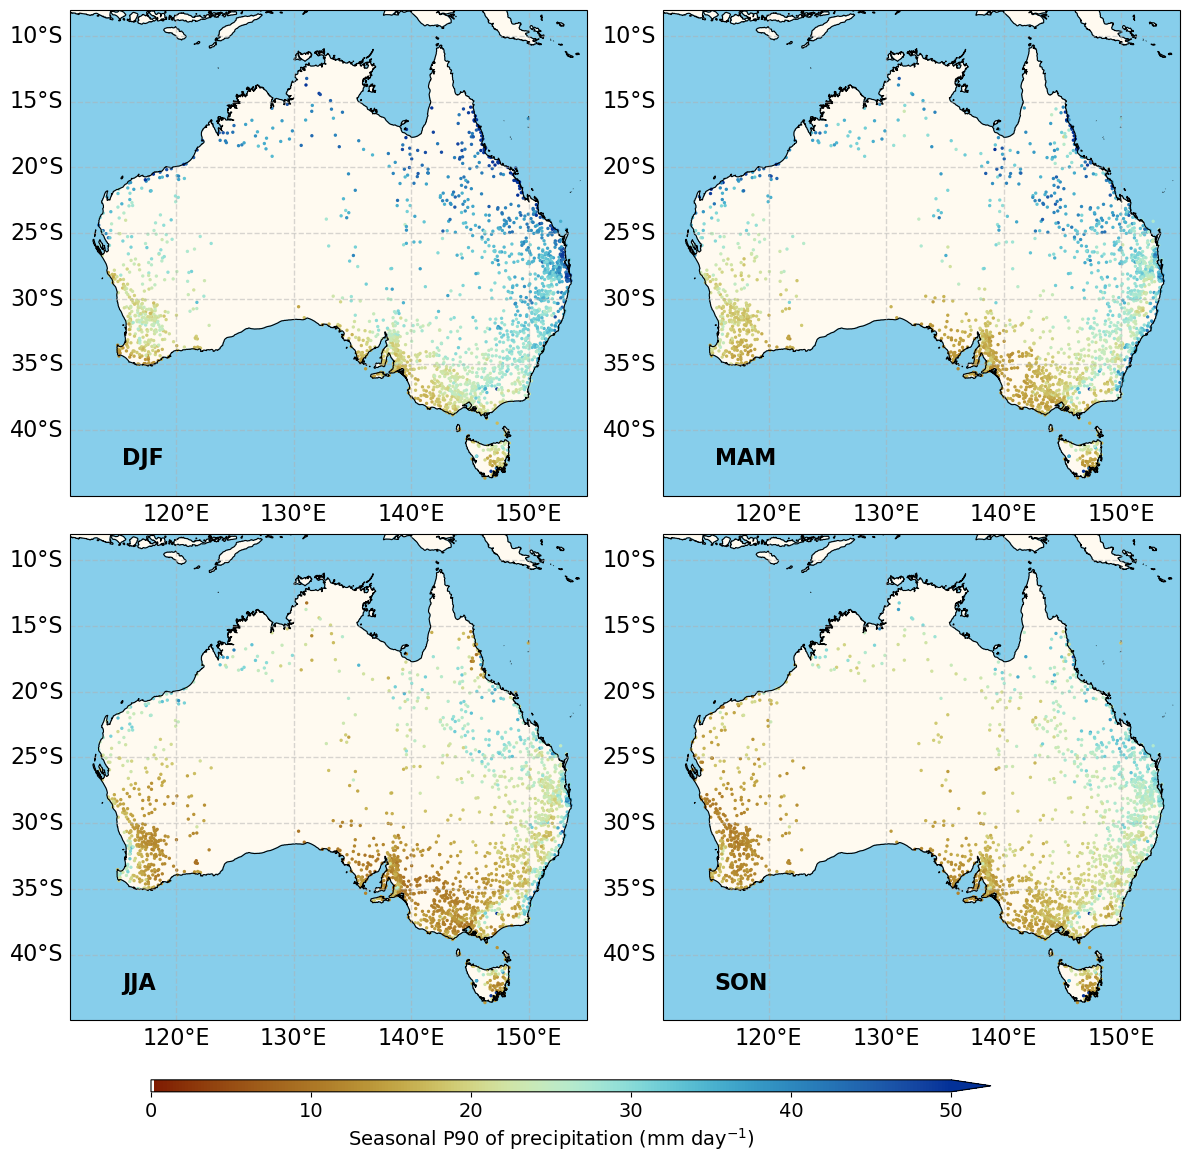

In [26]:
fig = plt.figure(figsize=(12,12))
for i, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    img = plt.scatter(df["Longitude"], df["Latitude"], s = 2, c= df_season[season], cmap=custom_cmap,vmin = 0, vmax=50,#norm=mcolors.LogNorm(vmax=1000),
                transform=ccrs.PlateCarree())
    # cbar = plt.colorbar(extend="max", pad =0.01)
    # cbar.ax.set_ylabel("P90 values (mm day$^{-1}$)")
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}  # Font size for longitude labels
    gl.ylabel_style = {'size': 16}  # Font size for latitude labels
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='skyblue')  
    ax1.set_ylim([-45,-8])
    ax1.set_xlim([111,155])
    ax1.text(0.1, 0.1, season, transform=ax1.transAxes, fontsize=16, color="k", fontweight="bold",
                 verticalalignment='top')
    ## have this so the plots are the same size
    regions_gdf.plot(ax=ax1, color="w", edgecolor="w", alpha=0,zorder=0)
plt.tight_layout()
fig.subplots_adjust(bottom = 0.13)

cbar_ax = fig.add_axes([0.13, 0.078, 0.7, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(img,  cax = cbar_ax, orientation = "horizontal",extend ="max")#,ticks=[-1,1])
cbar.ax.set_xlabel("Seasonal P90 of precipitation (mm day$^{-1}$)")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_02_seasonal_P90_1960.png", dpi=200, bbox_inches="tight")

## Seasonal scale

In [9]:
# df= pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_daily_stations_500km.csv")

In [8]:
season_weight_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):#/scratch/k10/dl6968/all_AU_p90_qc ./data/all_AU_p90_500km/
    df_scale = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1960_500km/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_weight_dict[seasons].append( df_scale.loc[seasons].values[0])

100%|██████████| 2070/2070 [01:30<00:00, 22.98it/s]


In [9]:
season_num_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):#/scratch/k10/dl6968/all_AU_p90_qc ./data/all_AU_p90_500km/
    df_scale = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1960_500km/{spec_id}_event_num_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_num_dict[seasons].append( df_scale.loc[seasons].values[0])

100%|██████████| 2070/2070 [01:16<00:00, 27.10it/s]


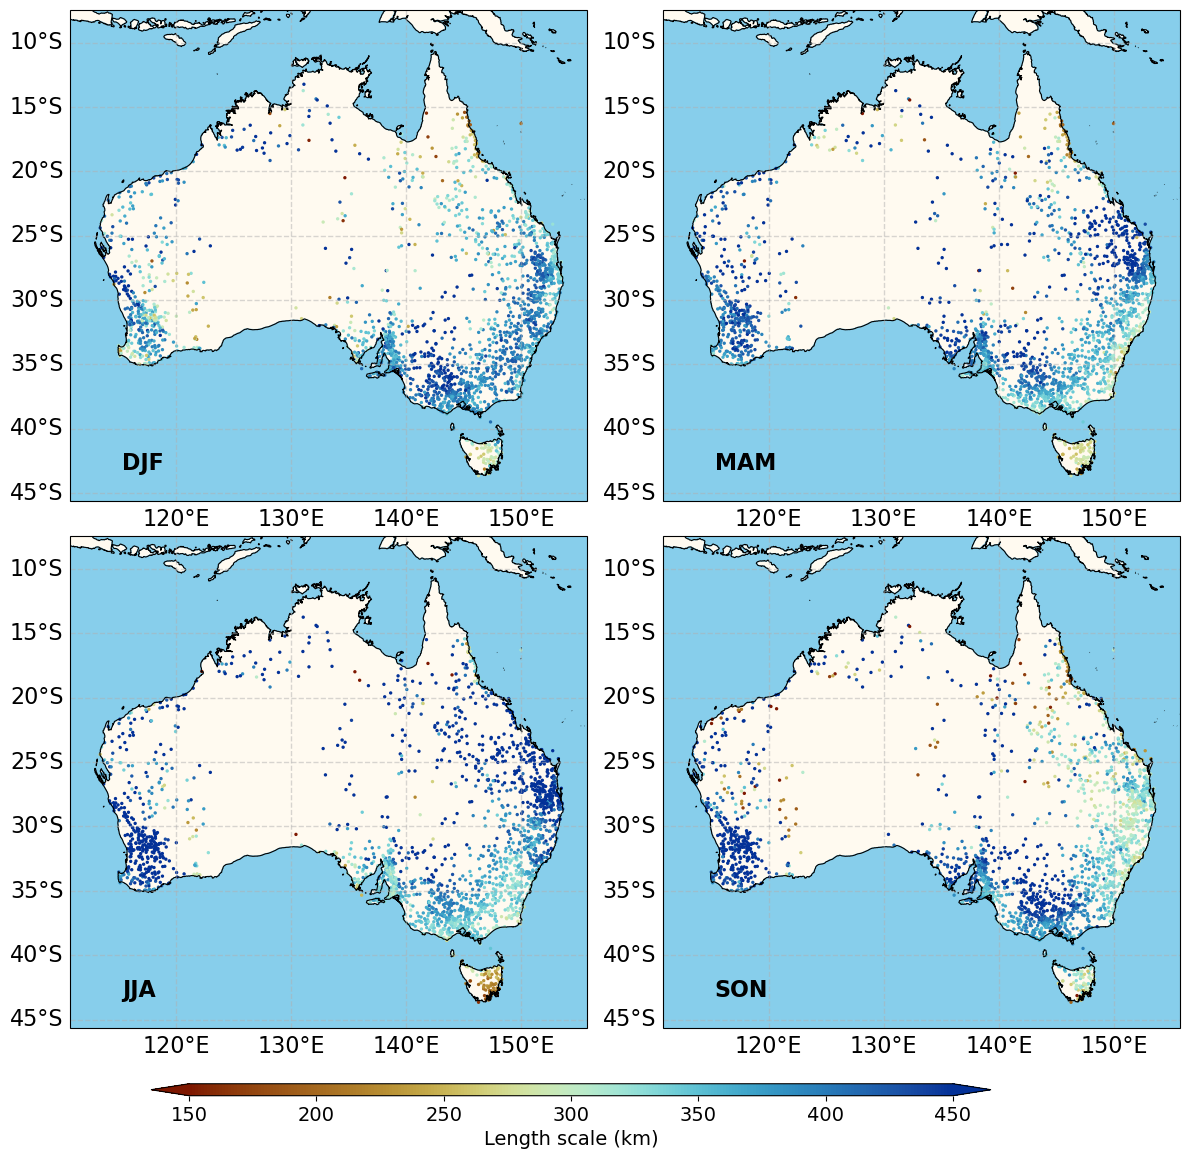

In [31]:
fig = plt.figure(figsize=(12,12))
cmap = "cmc.roma"
vmin=150
vmax=450
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1, projection=ccrs.PlateCarree())
        
        
    img = plt.scatter(df["Longitude"], df["Latitude"], s=2, c= season_weight_dict[seasons], cmap=cmap, vmin=vmin,vmax=vmax, 
                transform=ccrs.PlateCarree())
    # cbar = plt.colorbar(extend="max")
    # cbar.ax.set_ylabel("Event number")
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}  # Font size for longitude labels
    gl.ylabel_style = {'size': 16}
    # ax1.set_title(seasons)
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='skyblue')  
    regions_gdf.plot(ax=ax1, color="w", edgecolor="w", alpha=0,zorder=0)
    ax1.text(0.1, 0.1, seasons, transform=ax1.transAxes, fontsize=16, color="k", fontweight="bold",
                 verticalalignment='top')
plt.tight_layout()
fig.subplots_adjust(bottom = 0.13)
cbar_ax = fig.add_axes([0.13, 0.078, 0.7, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(img,  cax = cbar_ax, orientation = "horizontal",extend ="both")#,ticks=[-1,1])
cbar.ax.set_xlabel("Length scale (km)")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_04_seasonal_scale_1960.png", dpi=200, bbox_inches="tight")

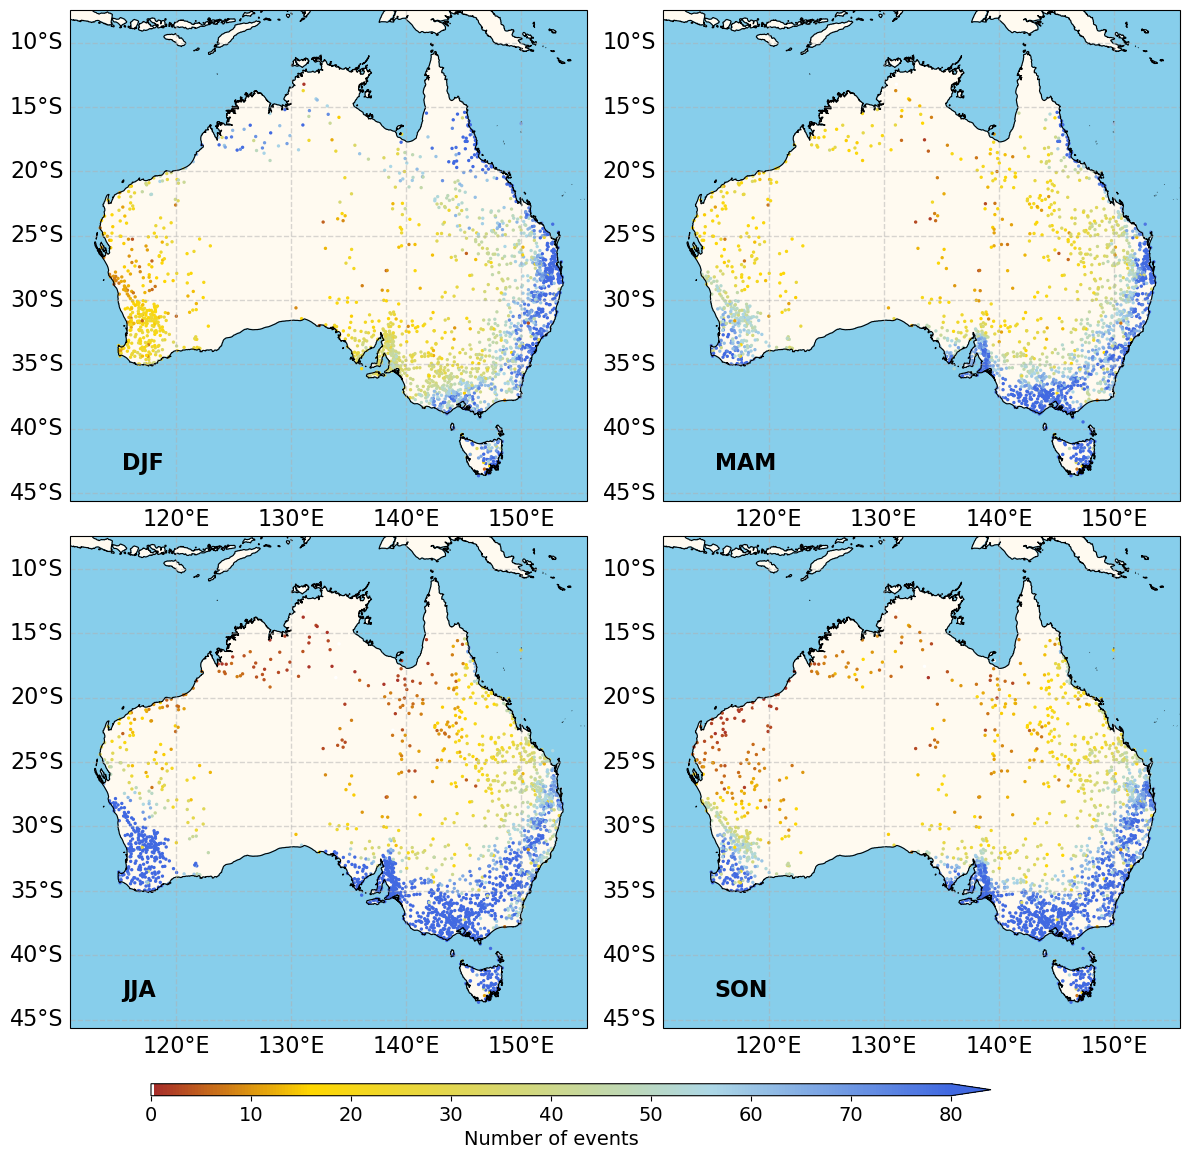

In [32]:
fig = plt.figure(figsize=(12,12))
# Define color segments
colors = [
    (0, "brown"),    
    (0.2, "gold"), 
    (0.7, "lightblue"),
    (1, "royalblue")      
]
# colors[0] = [1, 1, 1, 1]

# Create custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

new_colors = custom_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
new_colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
new_cmap = LinearSegmentedColormap.from_list("Custom_cmap", new_colors)
cmap = new_cmap
vmin=0
vmax=80
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1, projection=ccrs.PlateCarree())
        
        
    img = plt.scatter(df["Longitude"], df["Latitude"], s=2, c= season_num_dict[seasons], cmap=cmap, vmin=vmin,vmax=vmax, 
                transform=ccrs.PlateCarree())
    # cbar = plt.colorbar(extend="max")
    # cbar.ax.set_ylabel("Event number")
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}  # Font size for longitude labels
    gl.ylabel_style = {'size': 16}
    # ax1.set_title(seasons)
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='skyblue')  
    regions_gdf.plot(ax=ax1, color="w", edgecolor="w", alpha=0,zorder=0)
    ax1.text(0.1, 0.1, seasons, transform=ax1.transAxes, fontsize=16, color="k", fontweight="bold",
                 verticalalignment='top')
plt.tight_layout()
fig.subplots_adjust(bottom = 0.13)
cbar_ax = fig.add_axes([0.13, 0.078, 0.7, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(img,  cax = cbar_ax, orientation = "horizontal",extend ="max")#,ticks=[-1,1])
cbar.ax.set_xlabel("Number of events")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_05_seasonal_count_1960.png", dpi=200, bbox_inches="tight")

In [41]:
df =df.drop(columns=["Unnamed: 0.1", "level_0", "index", "Unnamed: 0"])

In [42]:
df_500km = pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_daily_stations_500km.csv",index_col=0)
df_both = df[df["ID"].isin(df_500km["ID"])].reset_index()

In [44]:
season_1960_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
season_500km_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}

for spec_id in tqdm(df["ID"],leave=True, position=0):
    df_scale_1960 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1960_500km/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    df_scale_500 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_500km/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_1960_dict[seasons].append( df_scale_1960.loc[seasons].values[0])
        season_500km_dict[seasons].append( df_scale_500.loc[seasons].values[0])

100%|██████████| 2070/2070 [01:06<00:00, 31.13it/s]


In [82]:
def percent_diff(var1, var2):
    return ((var1-var2) / ((var1+var2) / 2) )*100

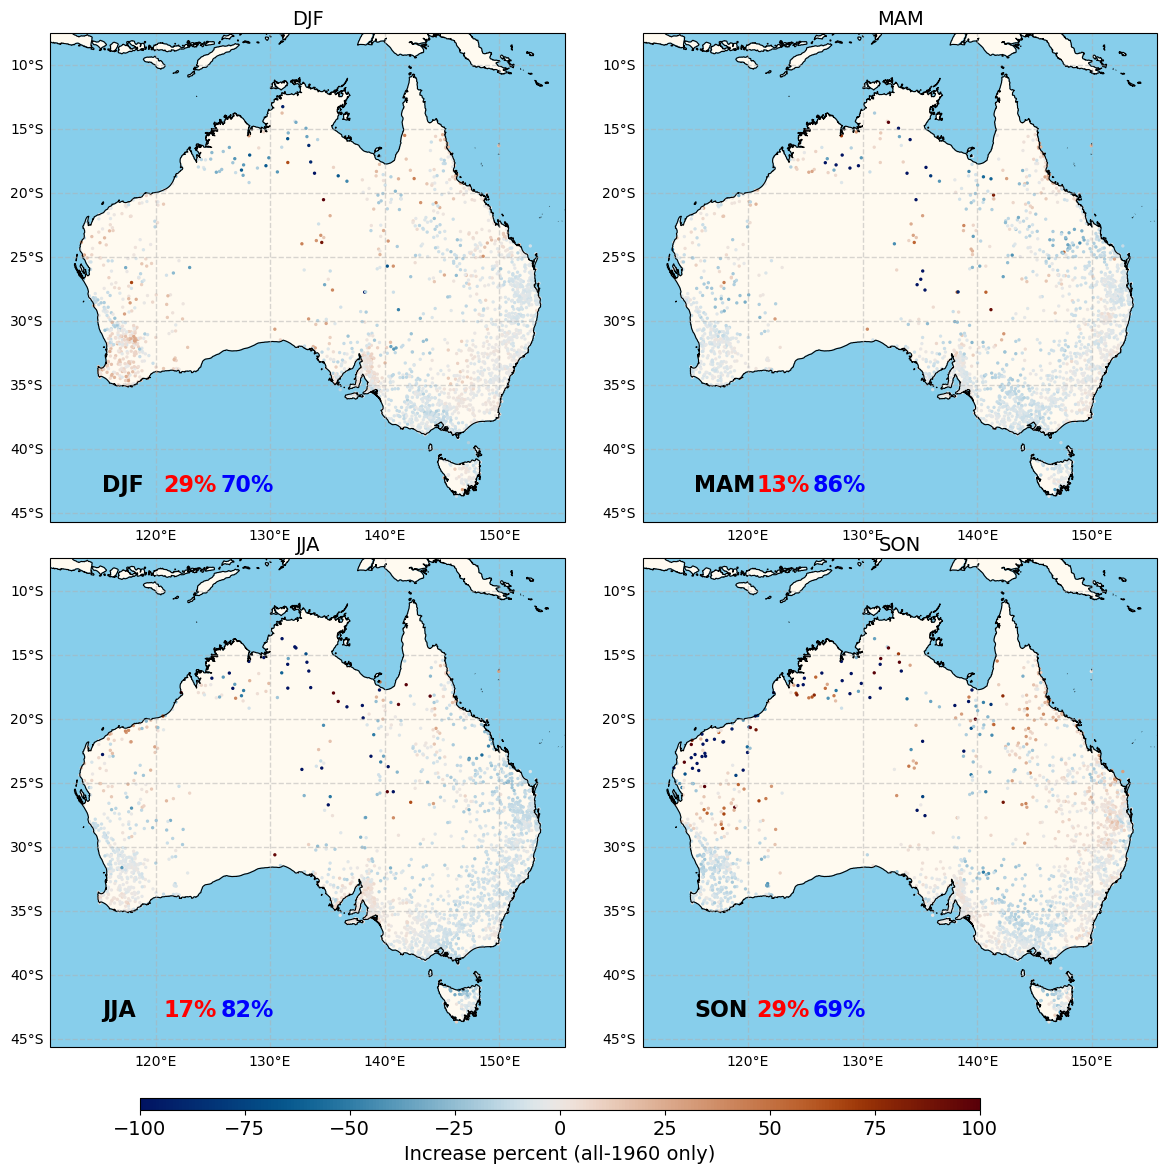

In [101]:
fig = plt.figure(figsize=(12,12))
cmap = "cmc.vik"
vmin=-100
vmax=100
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1, projection=ccrs.PlateCarree())
    
    season_percent = percent_diff(np.array(season_500km_dict[seasons]),np.array(season_1960_dict[seasons]))

    img = plt.scatter(df_both["Longitude"], df_both["Latitude"], s=2, c= season_percent, cmap=cmap, vmin=vmin,vmax=vmax, 
                transform=ccrs.PlateCarree())
    # cbar = plt.colorbar()
    # cbar.ax.set_ylabel()
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax1.set_title(seasons)
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='skyblue')  
    regions_gdf.plot(ax=ax1, color="w", edgecolor="w", alpha=0,zorder=0)
    ax1.text(0.1, 0.1, seasons, transform=ax1.transAxes, fontsize=16, color="k", fontweight="bold",
                 verticalalignment='top')
    more = len(np.argwhere(season_percent>0))/len(season_percent)*100
    less = len(np.argwhere(season_percent<0))/len(season_percent)*100
    ax1.text(0.22, 0.1, f"{int(more)}%", transform=ax1.transAxes, fontsize=16, color="r", fontweight="bold",
                 verticalalignment='top')
    ax1.text(0.33, 0.1, f"{int(less)}%", transform=ax1.transAxes, fontsize=16, color="b", fontweight="bold",
                 verticalalignment='top')
plt.tight_layout()
fig.subplots_adjust(bottom = 0.13)
cbar_ax = fig.add_axes([0.13, 0.078, 0.7, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(img,  cax = cbar_ax, orientation = "horizontal")#,ticks=[-1,1])
cbar.ax.set_xlabel("Increase percent (all-1960 only)")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_diff_map_1960.png", dpi=200, bbox_inches="tight")

In [92]:
len(np.argwhere(season_percent>0))/len(season_percent)

0.2961352657004831

Text(0, 0.5, 'Increase percent (%)')

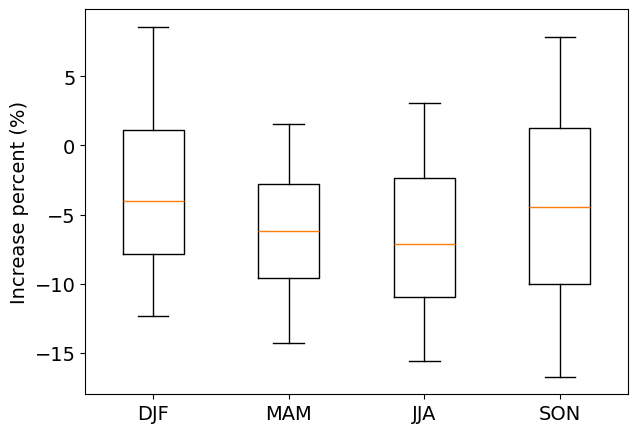

In [89]:
plt.figure(figsize=(7,5))
season_box = []
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]): 
    season_percent = percent_diff(np.array(season_500km_dict[seasons]),np.array(season_1960_dict[seasons]))
    season_box.append(season_percent[~np.isnan(season_percent)])
_ = plt.boxplot(season_box,showfliers=False, whis=(10,90))
_ = plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
plt.ylabel("Increase percent (%)")
# plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_diff_boxplot_1960.png", dpi=200, bbox_inches="tight")

## Boxplots

In [10]:
def nrm_season_weighted(df_in, id_df):
    djf_scale = np.array([df_in[df_in["ID"]==spec_id]["DJF"].values[0] for spec_id in id_df])
    mam_scale = np.array([df_in[df_in["ID"]==spec_id]["MAM"].values[0] for spec_id in id_df])
    jja_scale = np.array([df_in[df_in["ID"]==spec_id]["JJA"].values[0] for spec_id in id_df])
    son_scale = np.array([df_in[df_in["ID"]==spec_id]["SON"].values[0] for spec_id in id_df])
    
    djf_valid = djf_scale[~np.isnan(djf_scale)]
    mam_valid = mam_scale[~np.isnan(mam_scale)]
    jja_valid = jja_scale[~np.isnan(jja_scale)]
    son_valid = son_scale[~np.isnan(son_scale)]
    
    # djf_valid[djf_valid>1500] = 1500
    # mam_valid[mam_valid>1500] = 1500
    # jja_valid[jja_valid>1500] = 1500
    # son_valid[son_valid>1500] = 1500
    return [djf_valid, mam_valid, jja_valid, son_valid]

In [11]:
season_weight_dict["ID"] = df["ID"].values
df_season_weight = pd.DataFrame.from_dict(season_weight_dict)

season_num_dict["ID"] = df["ID"].values
df_season_num = pd.DataFrame.from_dict(season_num_dict)

nrm_sub_wscale_dict = {}
nrm_sub_num_dict = {}
for regions in stations_with_regions["code"].unique()[:-1]:
    nrm_sub_wscale_dict[regions] = nrm_season_weighted(df_season_weight,stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_sub_num_dict[regions] = nrm_season_weighted(df_season_num,stations_with_regions[stations_with_regions["code"]==regions]["ID"])

In [12]:
## change the keys so I can remember them easily
for nrm_dicts in [nrm_sub_wscale_dict,nrm_sub_num_dict]:
    nrm_dicts["SFW"] = nrm_dicts.pop("SSWFW")
    nrm_dicts["SFE"] = nrm_dicts.pop("SSWFE")
    nrm_dicts["VICW"] = nrm_dicts.pop("SSVW")
    nrm_dicts["VICE"] = nrm_dicts.pop("SSVE")
    nrm_dicts["TASW"] = nrm_dicts.pop("SSTW")
    nrm_dicts["TASE"] = nrm_dicts.pop("SSTE")

In [13]:
rcolors = [
     "blue",  "lightgray",  "salmon",
     "orange",  "black",  "fuchsia",
     "navy",  "lightgreen", "maroon",
     "red",  "cyan",  "dodgerblue",
     "tan", "darkgreen",  "darkcyan"
]
def index_to_letter_lower(index):
    return chr(96 + index)

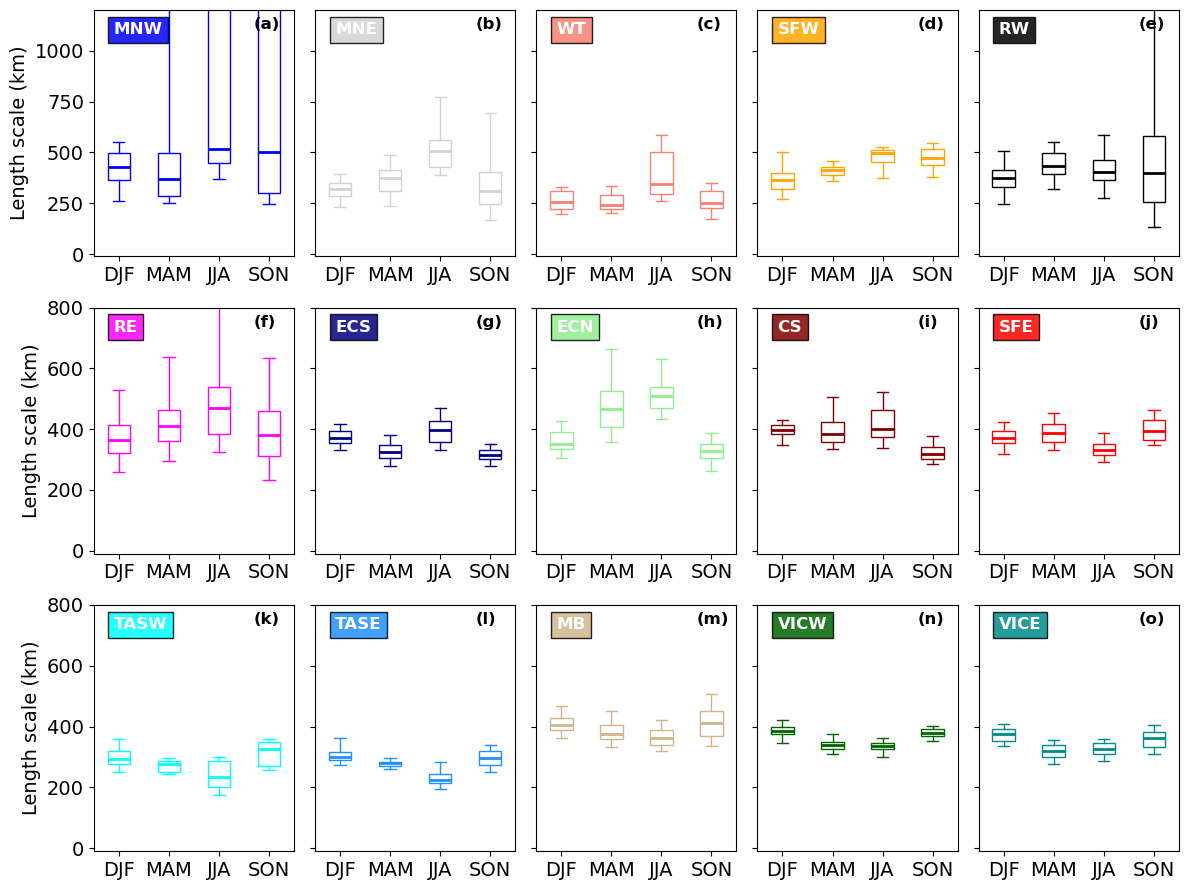

In [62]:
plt.figure(figsize=(12,9))
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    ax = plt.subplot(3,5,i+1)
    # if region=="MNW":
    #     nrm_sub_wscale_dict[region][2] = []
    #     nrm_sub_wscale_dict[region][3] = []
    boxes = plt.boxplot(nrm_sub_wscale_dict[region], whis=(5,95),
                        whiskerprops=dict(color=rcolors[i]), capprops=dict(color=rcolors[i]),
                        showfliers=False,patch_artist=True)
    for box in boxes['boxes']:
        box.set_edgecolor(rcolors[i])
        box.set_facecolor("w")
        box.set_linewidth(1) 
    for median in boxes['medians']:
        median.set_color(rcolors[i])  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
    if i % 5 == 0:
        plt.ylabel("Length scale (km)")
    else:
        ax.set_yticklabels([])
    ax.text(0.1, 0.95, region, transform=ax.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=rcolors[i], alpha=0.85))
    ax.text(0.8, 0.97, f"({index_to_letter_lower(i+1)})", transform=ax.transAxes, fontsize=12, color="k", fontweight="bold",
                 verticalalignment='top' )
    if i+1<=5:
        plt.ylim([-10,1200])
    else:
        plt.ylim([-10,800])
plt.tight_layout()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_1960_box_plot_scale.png", dpi=200, bbox_inches="tight")

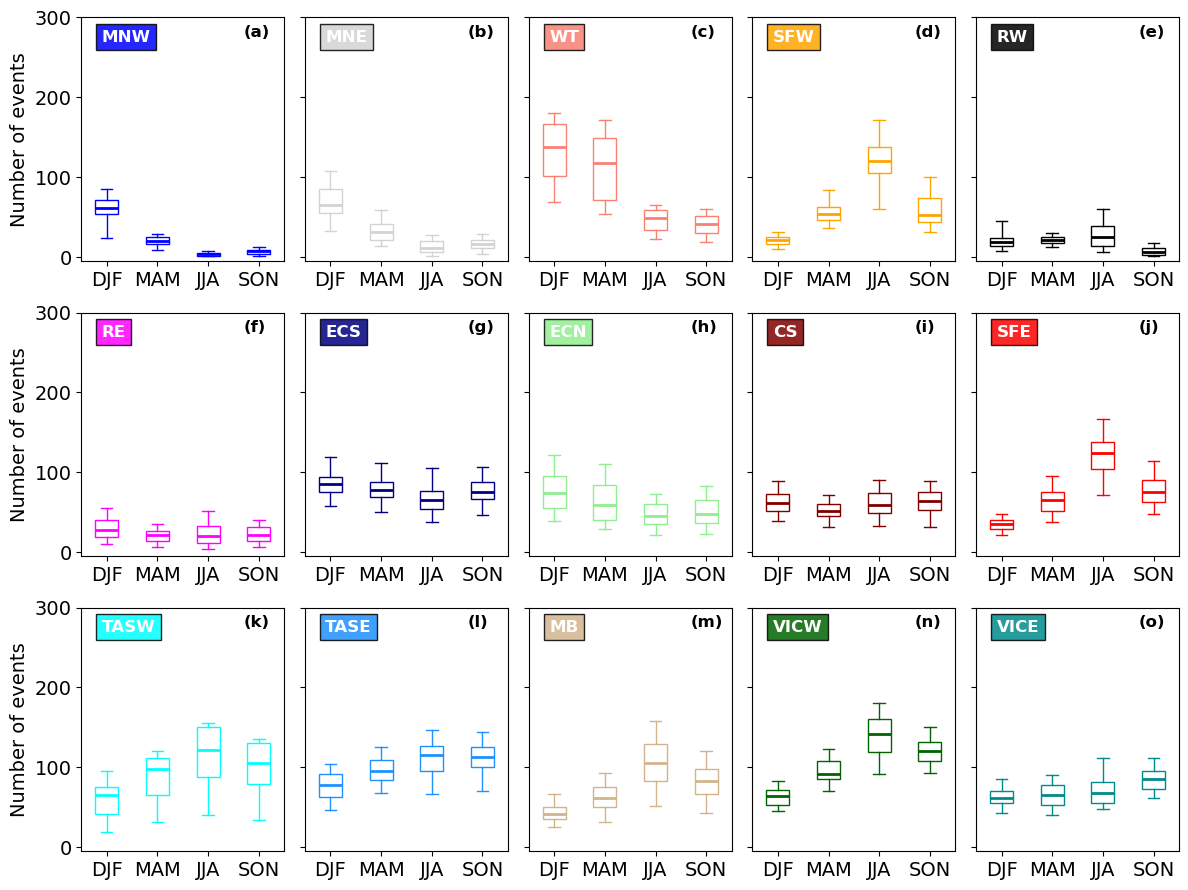

In [63]:
plt.figure(figsize=(12,9))
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    ax = plt.subplot(3,5,i+1)
    boxes = plt.boxplot(nrm_sub_num_dict[region], whis=(5,95),
                        whiskerprops=dict(color=rcolors[i]), capprops=dict(color=rcolors[i]),
                        showfliers=False,patch_artist=True)
    for box in boxes['boxes']:
        box.set_edgecolor(rcolors[i])
        box.set_facecolor("w")
        box.set_linewidth(1) 
    for median in boxes['medians']:
        median.set_color(rcolors[i])  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
    if i % 5 == 0:
        plt.ylabel("Number of events")
    else:
        ax.set_yticklabels([])
    ax.text(0.1, 0.95, region, transform=ax.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=rcolors[i], alpha=0.85))
    ax.text(0.8, 0.97, f"({index_to_letter_lower(i+1)})", transform=ax.transAxes, fontsize=12, color="k", fontweight="bold",
                 verticalalignment='top' )
    plt.ylim([-5,300])
plt.tight_layout()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_1960_box_plot_count.png", dpi=200, bbox_inches="tight")

In [14]:
import seaborn as sns
import scipy.stats as stats
from matplotlib.lines import Line2D


In [15]:
region_list = ["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]

In [16]:
def nrm_season_weighted(df_in, id_df):
    djf_scale = np.array([df_in[df_in["ID"]==spec_id]["DJF"].values[0] for spec_id in id_df])
    mam_scale = np.array([df_in[df_in["ID"]==spec_id]["MAM"].values[0] for spec_id in id_df])
    jja_scale = np.array([df_in[df_in["ID"]==spec_id]["JJA"].values[0] for spec_id in id_df])
    son_scale = np.array([df_in[df_in["ID"]==spec_id]["SON"].values[0] for spec_id in id_df])
    
    djf_valid = djf_scale#[~np.isnan(djf_scale)]
    mam_valid = mam_scale#[~np.isnan(mam_scale)]
    jja_valid = jja_scale#[~np.isnan(jja_scale)]
    son_valid = son_scale#[~np.isnan(son_scale)]
    
    # djf_valid[djf_valid>1500] = 1500
    # mam_valid[mam_valid>1500] = 1500
    # jja_valid[jja_valid>1500] = 1500
    # son_valid[son_valid>1500] = 1500
    return [djf_valid, mam_valid, jja_valid, son_valid]

In [17]:
season_weight_dict["ID"] = df["ID"].values
df_season_weight = pd.DataFrame.from_dict(season_weight_dict)

season_num_dict["ID"] = df["ID"].values
df_season_num = pd.DataFrame.from_dict(season_num_dict)

nrm_sub_wscale_dict = {}
nrm_sub_num_dict = {}
for regions in stations_with_regions["code"].unique()[:-1]:
    nrm_sub_wscale_dict[regions] = nrm_season_weighted(df_season_weight,stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_sub_num_dict[regions] = nrm_season_weighted(df_season_num,stations_with_regions[stations_with_regions["code"]==regions]["ID"])

In [18]:
## change the keys so I can remember them easily
for nrm_dicts in [nrm_sub_wscale_dict,nrm_sub_num_dict]:
    nrm_dicts["SFW"] = nrm_dicts.pop("SSWFW")
    nrm_dicts["SFE"] = nrm_dicts.pop("SSWFE")
    nrm_dicts["VICW"] = nrm_dicts.pop("SSVW")
    nrm_dicts["VICE"] = nrm_dicts.pop("SSVE")
    nrm_dicts["TASW"] = nrm_dicts.pop("SSTW")
    nrm_dicts["TASE"] = nrm_dicts.pop("SSTE")

In [19]:
mann_dict = {}

for iregion in region_list:
    mann_dict[iregion] = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
    for jregion in region_list:
        for iseason, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
            pvalue = stats.mannwhitneyu(nrm_sub_wscale_dict[iregion][iseason][~np.isnan(nrm_sub_wscale_dict[iregion][iseason])],
                                        nrm_sub_wscale_dict[jregion][iseason][~np.isnan(nrm_sub_wscale_dict[jregion][iseason])])[1]
            mann_dict[iregion][seasons].append(pvalue)

In [20]:
pvalue_djf = np.array([np.array(mann_dict[region]["DJF"]) for region in region_list])
pvalue_mam = np.array([np.array(mann_dict[region]["MAM"]) for region in region_list])
pvalue_jja = np.array([np.array(mann_dict[region]["JJA"]) for region in region_list])
pvalue_son = np.array([np.array(mann_dict[region]["SON"]) for region in region_list])
pvalue_matrix = [pvalue_djf, pvalue_mam, pvalue_jja, pvalue_son]

/jobfs/138666501.gadi-pbs/ipykernel_2521985/1742763259.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout so the colorbar doesn't overlap


<Figure size 1200x700 with 0 Axes>

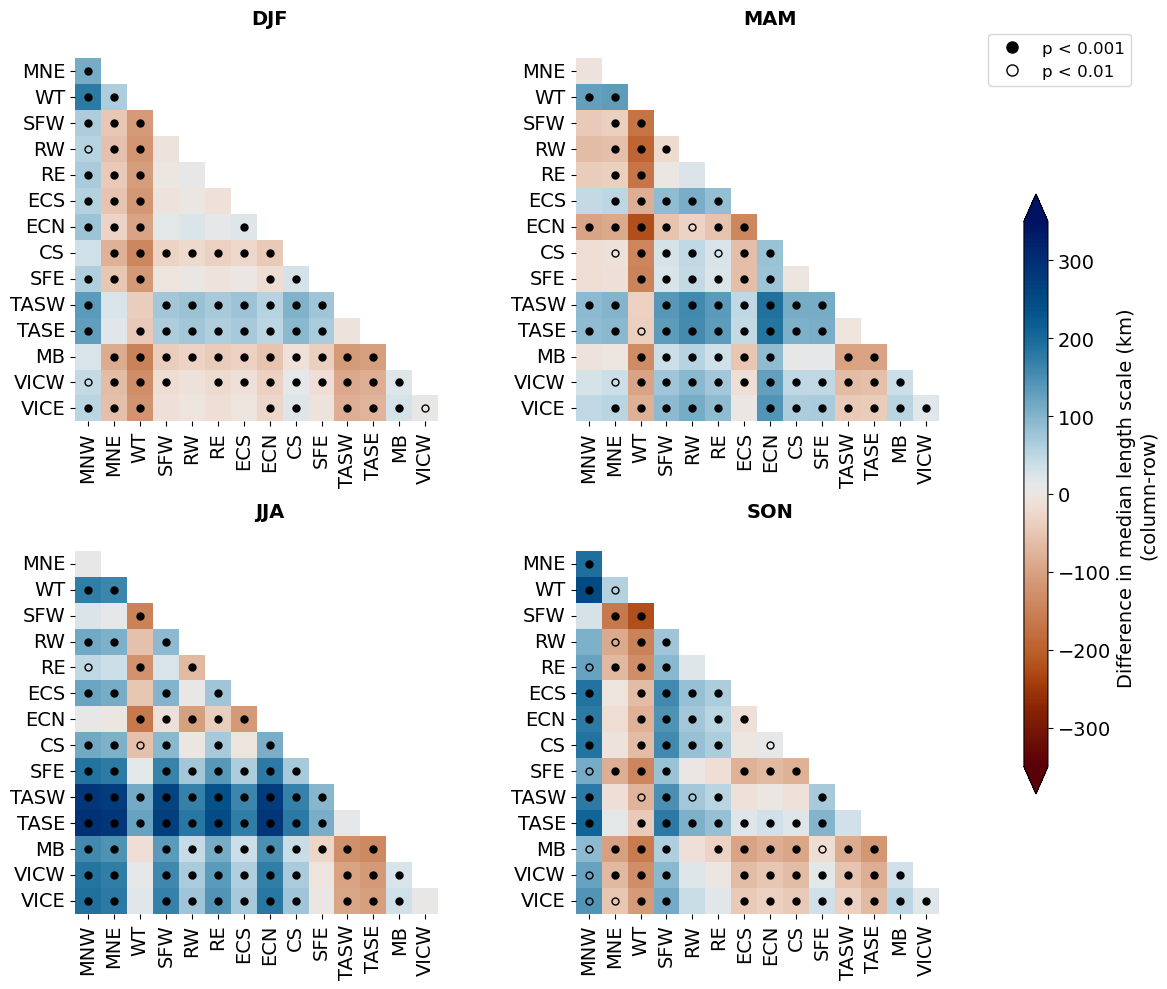

In [24]:
plt.figure()
# Sample figure and axes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
axes = [ax1, ax2, ax3, ax4]

# Loop over seasons and subplots
for iseason, season, ax in zip(range(4), ["DJF", "MAM", "JJA", "SON"], axes):

    # Generate your data (using region_list from your context)
    diff= np.array([np.nanmedian(nrm_sub_wscale_dict[region][iseason])
                           for region in region_list])
    diff_matrix= diff[None, :] - diff[:, None]

    # Create an upper-triangular mask if needed
    mask = np.zeros_like(diff_matrix)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        # Disable the colorbar for each heatmap (cbar=False)
        g1 = sns.heatmap(diff_matrix, mask=mask, square=True,
                         vmin=-350, vmax=350, cmap="cmc.vik_r", cbar=False, ax=ax)
        # Set the tick positions and labels; ensure the number matches region_list length
        n_regions = len(region_list)-1
        ax.set_xticks(np.arange(n_regions) + 0.5)
        ax.set_xticklabels(region_list[:-1], rotation=90)
        ax.set_yticks(np.arange(n_regions) + 1.5)
        ax.set_yticklabels(region_list[1:], rotation=0)
        ax.set_title(season,fontweight="bold")
# Overlay markers based on p-value thresholds.
    # Iterate over each cell in the p-value matrix.
    for i in range(pvalue_matrix[iseason].shape[0]):
        for j in range(pvalue_matrix[iseason].shape[1]):
            p = pvalue_matrix[iseason][i, j]
            if p < 0.001 and mask[i,j]==False:
                # Solid black dot
                markerfacecolor = "black"
                markeredgecolor = "black"
            elif p < 0.01 and mask[i,j]==False:
                # Hollow dot (no face color, just edge)
                markerfacecolor = "none"
                markeredgecolor = "black"
            else:
                continue  # Do nothing if p-value doesn't meet criteria.
            # Plot the marker at the center of cell (i, j)
            ax.plot(j + 0.5, i + 0.5, marker='o', markersize=5,
                    markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
    plt.tight_layout() 
# Create a single colorbar for the entire figure.
# Define the position of the colorbar axis: [left, bottom, width, height]
cbar_ax = f.add_axes([0.92, 0.2, 0.02, 0.6])
# Create a ScalarMappable with the same colormap and normalization as the heatmaps
norm = plt.Normalize(vmin=-350, vmax=350)
sm = plt.cm.ScalarMappable(norm=norm, cmap="cmc.vik_r")
sm.set_array([])  # This is needed for the colorbar
f.colorbar(sm, cax=cbar_ax, label="Difference in median length scale (km) \n(column-row)",extend="both")
# Create legend elements for the p-value markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markeredgecolor='black', markersize=8, label='p < 0.001'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
           markeredgecolor='black', markersize=8, label='p < 0.01')
]

# Add a common legend to the figure.
# Adjust bbox_to_anchor and loc as needed.
f.legend(handles=legend_elements, loc='lower center', ncol=1, bbox_to_anchor=(0.95, 0.9))
plt.tight_layout()  # Adjust layout so the colorbar doesn't overlap
# plt.show()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_Mann_1960.png", dpi=200, bbox_inches="tight")

In [22]:
wilcox_dict = {}
for region in region_list:
    wilcox_dict[region] = np.zeros((4,4))
    for iseason, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
        for jseason,_ in enumerate(["DJF", "MAM", "JJA", "SON"]):
            if iseason == jseason:
                wilcox_dict[region][iseason,jseason] = 1
            else:
                mask = ~np.isnan(nrm_sub_wscale_dict[region][iseason]) & ~np.isnan(nrm_sub_wscale_dict[region][jseason])
                pval_wilx = stats.wilcoxon(nrm_sub_wscale_dict[region][iseason][mask],nrm_sub_wscale_dict[region][jseason][mask])[1]
                wilcox_dict[region][iseason,jseason] = pval_wilx


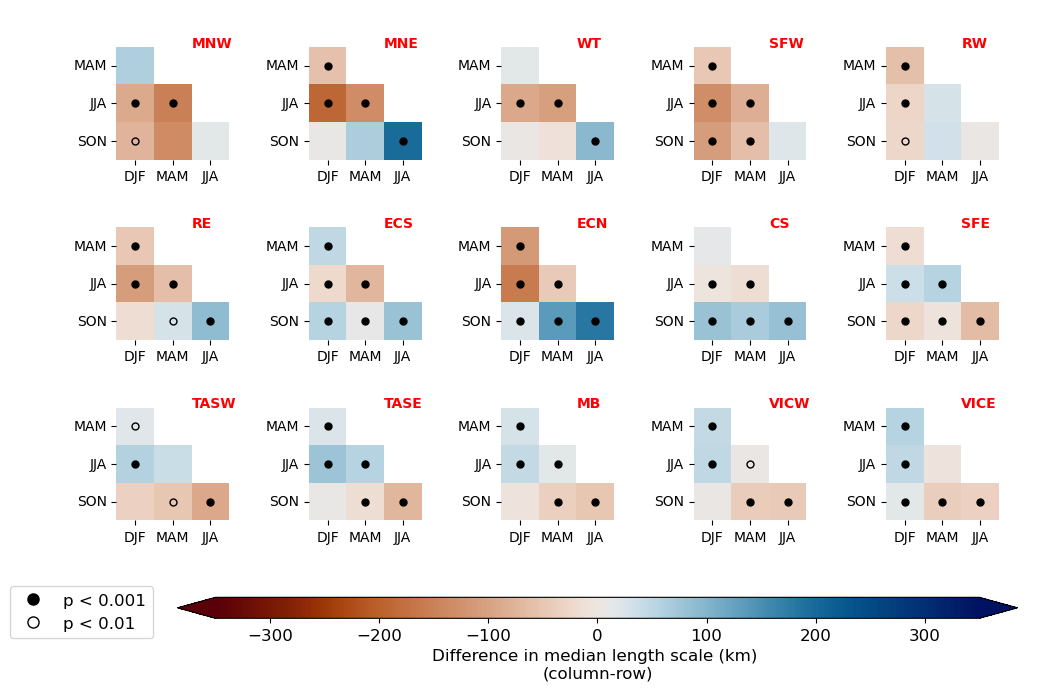

In [25]:

fig = plt.figure()
for ir, region in enumerate(region_list):
    ax=fig.add_subplot(3,5,ir+1)
    # region = "WT"
    region_self = np.array([np.nanmedian(nrm_sub_wscale_dict[region][iseason]) for iseason in range(0,4)])
    self_matrix = region_self[None, :] - region_self[:, None]
    
    # Create an upper-triangular mask if needed
    mask = np.zeros_like(self_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        # Disable the colorbar for each heatmap (cbar=False)
        g1 = sns.heatmap(self_matrix, mask=mask, square=True,
                         vmin=-350, vmax=350, cmap="cmc.vik_r", cbar=False, ax=ax)
        # Set the tick positions and labels; ensure the number matches region_list length
        n_seasons = 4-1
        ax.set_xticks(np.arange(n_seasons) + 0.5)
        ax.set_xticklabels(["DJF","MAM","JJA"], rotation=0,fontsize=10)
        ax.set_yticks(np.arange(n_seasons) + 1.5)
        ax.set_yticklabels(["MAM","JJA","SON"], rotation=0,fontsize=10)
    plt.text(2,1,region, fontweight="bold",color="r")
    # plt.title(region, fontweight="bold")
    for i in range(wilcox_dict[region].shape[0]):
        for j in range(wilcox_dict[region].shape[1]):
            p = wilcox_dict[region][i, j]
            if p < 0.001 and mask[i,j]==False:
                # Solid black dot
                markerfacecolor = "black"
                markeredgecolor = "black"
            elif p < 0.01 and mask[i,j]==False:
                # Hollow dot (no face color, just edge)
                markerfacecolor = "none"
                markeredgecolor = "black"
            else:
                continue  # Do nothing if p-value doesn't meet criteria.
            # Plot the marker at the center of cell (i, j)
            ax.plot(j + 0.5, i + 0.5, marker='o', markersize=5,
                    markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
# plt.tight_layout() 
fig.subplots_adjust(bottom = 0.15)


cbar_ax = fig.add_axes([0.18, 0.01, 0.7, 0.03]) #[left, bottom, width, height]
norm = plt.Normalize(vmin=-350, vmax=350)
sm = plt.cm.ScalarMappable(norm=norm, cmap="cmc.vik_r")
sm.set_array([])  # This is needed for the colorbar
cbar = fig.colorbar(sm,  cax = cbar_ax, orientation = "horizontal",extend ="both")#,ticks=[-1,1])
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xlabel("Difference in median length scale (km) \n(column-row)",fontsize=12)
# Create legend elements for the p-value markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markeredgecolor='black', markersize=8, label='p < 0.001'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
           markeredgecolor='black', markersize=8, label='p < 0.01')
]

# Add a common legend to the figure.
# Adjust bbox_to_anchor and loc as needed.
fig.legend(handles=legend_elements, loc='lower center', ncol=1, bbox_to_anchor=(0.10, -0.03))
 # Adjust layout so the colorbar doesn't overlap
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_wilcox_1960.png", dpi=200, bbox_inches="tight")